In [1]:
import warnings, numpy as np, pandas as pd
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy.spatial import ConvexHull
from prophet import Prophet
from scipy.stats import f_oneway, ttest_ind
from sklearn.decomposition import FactorAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [2]:
#Loading the data
df = pd.read_csv("raw_sales_data.csv")
print(df.shape)

#Preview the data
df.head()

(16, 8)


,Customer_ID,Customer_Name,Region,Total_Spend,Purchase_Frequency,Marketing_Spend,Seasonality_Index,Churned
0,101,John Doe,North,5000,12,2000,1.2,No
1,102,Jane Smith,South,3000,8,1500,1.0,Yes
2,103,Sam Brown,East,4500,10,1800,1.1,No
3,104,Linda Johnson,West,2500,5,1000,0.9,Yes
4,105,Michael Lee,North,7000,15,2500,1.3,No


In [3]:
# 1. Data Preprocessing and Cleaning

# a. Handling missing values

#Check for numeric columns
df['Total_Spend'].fillna(df['Total_Spend'].median(), inplace=True)


#Check for categorical columns
df['Region'].fillna(df['Region'].mode()[0], inplace=True)


# b. Detecting and handling outliers
#Using Z-score method

from scipy.stats import zscore

# Calculate Z-scores for 'Total_Spend' and 'Marketing_Spend'
z_scores = zscore(df[['Total_Spend', 'Marketing_Spend']])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
df_clean = df[filtered_entries]


# c. Standardize categorical variables for consistency
df['Region'] = df['Region'].str.strip().str.title()
df['Churned'] = df['Churned'].astype(str).str.strip().str.capitalize()
df['Churned'] = df['Churned'].map({'Yes' : 1, 'No' : 0})
df_clean.to_csv("cleaned_sales_data.csv", index=False)

R² Score: 0.7932581750365791
Mean Squared Error: 178185.61039034836
Accuracy 1.0
Confusion Matrix:
 [[2 0]
 [0 2]]


12:10:15 - cmdstanpy - INFO - Chain [1] start processing
12:10:16 - cmdstanpy - INFO - Chain [1] done processing


Text(0.5, 1.0, 'Monthly Sales Forecast')

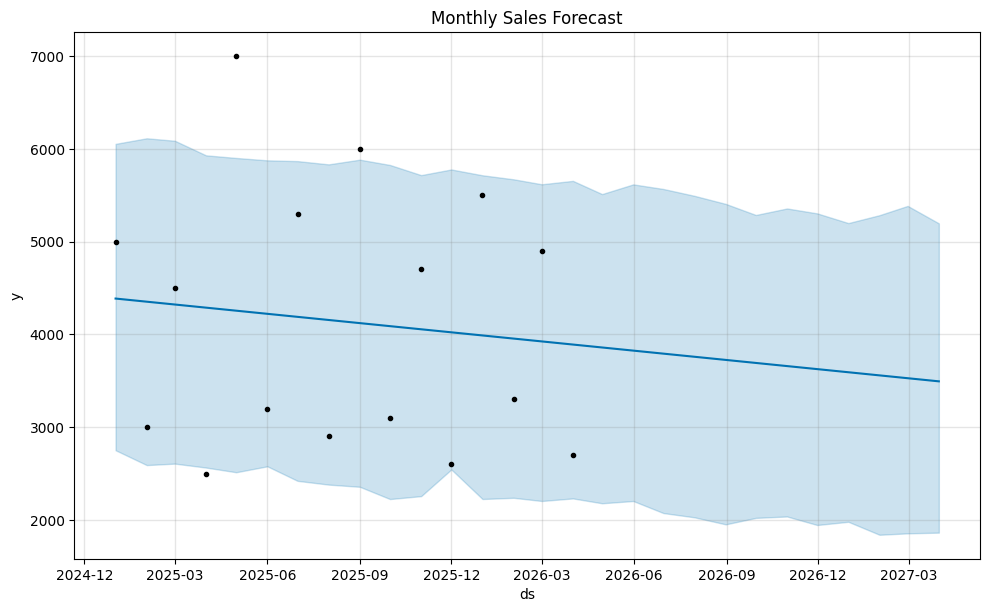

In [4]:
# 2. Predictive Modeling for Sales Forecasting

# a. Linear Regression: Predict Sales Based on Marketing Spend & Seasonality
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# load and prepare data
df = pd.read_csv("cleaned_sales_data.csv")
a = df[['Marketing_Spend', 'Seasonality_Index']]
b = df['Total_Spend']

# split data
a_train, a_test, b_train, b_test = train_test_split(a, b, test_size=0.2, random_state=42)

# train model
model = LinearRegression()
model.fit(a_train, b_train)

#predict and evaluate
y_pred = model.predict(a_test)
print('R² Score:', r2_score(b_test, y_pred))
print('Mean Squared Error:', mean_squared_error(b_test, y_pred))


# b. Logistic Regression: Predict Customer Churn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

# Prepare data
c = df[['Total_Spend', 'Purchase_Frequency', 'Marketing_Spend', 'Seasonality_Index']]
d = df['Churned']

# Split data
c_train, c_test, d_train, d_test = train_test_split(c, d, test_size=0.2, random_state=42)

# Train model
log_model = LogisticRegression()
log_model.fit(c_train, d_train)

# Predict and evaluate
y_pred = log_model.predict(c_test)
print('Accuracy', accuracy_score(d_test, y_pred))
print('Confusion Matrix:\n', confusion_matrix(d_test, y_pred))


# c. Time Series Forecasting: Predict Monthly Sales

# As we don't have a date column, we will simulate a time series by crearing Purchase_Date column
df['Purchase_Date'] = pd.date_range(start='2025-01-01', periods= len(df), freq='M')

# Aggregating monthly sales
monthly_sales = df.groupby(df['Purchase_Date'].dt.to_period('M'))['Total_Spend'].sum().reset_index()
monthly_sales['Month'] = monthly_sales['Purchase_Date'].dt.to_timestamp()
monthly_sales.set_index('Month', inplace=True)

#Prepare data for Prophet
df_prophet = monthly_sales.reset_index()[['Month', 'Total_Spend']]
df_prophet.columns = ['ds', 'y']

# fit model
model = Prophet()
model.fit(df_prophet)

# Forecast future sales
future = model.make_future_dataframe(periods=12, freq='M')
forecast = model.predict(future)

# Plot forecast
fig = model.plot(forecast)
plt.title('Monthly Sales Forecast')

In [5]:
# 3. Statistical Analysis for Business Insights

# a. ANOVA: Compare Sales Across Regions
# group sales by region
north = df[df['Region'] == 'North']['Total_Spend']
south = df[df['Region'] == 'South']['Total_Spend']
east = df[df['Region'] == 'East']['Total_Spend']
west = df[df['Region'] == 'West']['Total_Spend']

# ANOVA operation
f_stat, p_value = f_oneway(north, south, east, west )
print('F-statistic:', f_stat)
print('P-value:', p_value)


# b. Hypothesis Testing: Impact of Promotions on Sales
marketing_split = df['Marketing_Spend'].median()

# Split data into two groups based on marketing spend
high_marketing = df[df['Marketing_Spend'] > marketing_split]['Total_Spend']
low_marketing = df[df['Marketing_Spend'] <= marketing_split]['Total_Spend']

# t-test operation
t_stat, p_value = ttest_ind(high_marketing, low_marketing)
print('T-statistic:', t_stat)
print('P-value:', p_value)


#c. Factor Analysis: To identify key drivers influencing customer purchase decisions.

# Selecting features
purchase_drivers = df[['Purchase_Frequency', 'Marketing_Spend', 'Seasonality_Index']]
data_scaler = StandardScaler()
scaled_inputs = data_scaler.fit_transform(purchase_drivers)

# Applying Factor Analysis
factor_model = FactorAnalysis(n_components=2)
component_scores = factor_model.fit_transform(scaled_inputs)

# Converting to DataFrame
factor_df = pd.DataFrame(component_scores, columns=['Factor1', 'Factor2'])
print(factor_df.head())



F-statistic: 39.719626168224295
P-value: 1.6512569414092803e-06
T-statistic: 8.018868232385392
P-value: 1.3323981353003831e-06
    Factor1   Factor2
0  0.761633  0.417256
1 -0.404612  0.436385
2  0.239568  0.517491
3 -1.403997  0.874524
4  1.761017 -0.020884


              precision    recall  f1-score   support

          No       1.00      1.00      1.00         2
         Yes       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



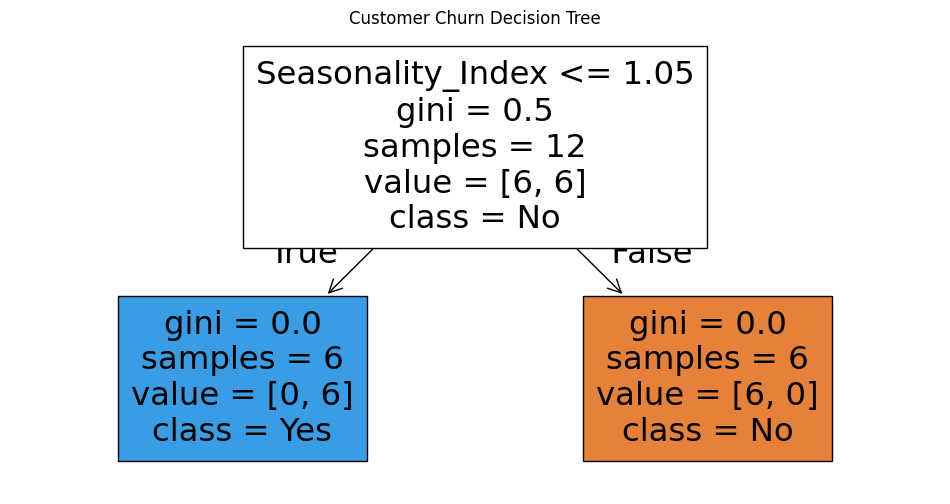

Predictions exported to churn_predictions.csv


In [6]:

# 1. Decision Trees: Segment Customers by Purchasing Behavior

# Features and target
customer_features = df[['Purchase_Frequency', 'Marketing_Spend', 'Seasonality_Index']]
churn_labels = df['Churned']

# Train-test split
features_train, features_test, labels_train, labels_test = train_test_split(
    customer_features, churn_labels, test_size=0.2, random_state=42
)

# Train decision tree
tree_model = DecisionTreeClassifier(max_depth=3)
tree_model.fit(features_train, labels_train)

# Predict and evaluate
labels_pred = tree_model.predict(features_test)
print(classification_report(labels_test, labels_pred))

# Visualizing the decision tree
plt.figure(figsize=(12, 6))
plot_tree(tree_model, feature_names=customer_features.columns, class_names=['No', 'Yes'], filled=True)
plt.title("Customer Churn Decision Tree")
plt.show()


# Creating a DataFrame with predictions
results_df = features_test.copy()
results_df['Actual_Churn'] = labels_test
results_df['Predicted_Churn'] = labels_pred

# Maping binary values back to labels
results_df['Actual_Churn_Label'] = results_df['Actual_Churn'].map({0: 'No', 1: 'Yes'})
results_df['Predicted_Churn_Label'] = results_df['Predicted_Churn'].map({0: 'No', 1: 'Yes'})

# Exporting to CSV
results_df.to_csv("churn_predictions.csv", index=False)
print("Predictions exported to churn_predictions.csv")



In [7]:
# 2. K-Means Clustering: Group Customers by Spending

# Selecting features
customer_spend_profile = df[['Total_Spend', 'Marketing_Spend', 'Purchase_Frequency']]
scaler = StandardScaler()
scaled_spending = scaler.fit_transform(customer_spend_profile)

# Applying K-Means
kmeans = KMeans(n_clusters=3, random_state=42)
df['Spend_Segment'] = kmeans.fit_predict(scaled_spending)

# Viewing cluster assignments
print(df[['Customer_Name', 'Total_Spend', 'Spend_Segment']].head())


   Customer_Name  Total_Spend  Spend_Segment
0       John Doe         5000              2
1     Jane Smith         3000              0
2      Sam Brown         4500              2
3  Linda Johnson         2500              0
4    Michael Lee         7000              1


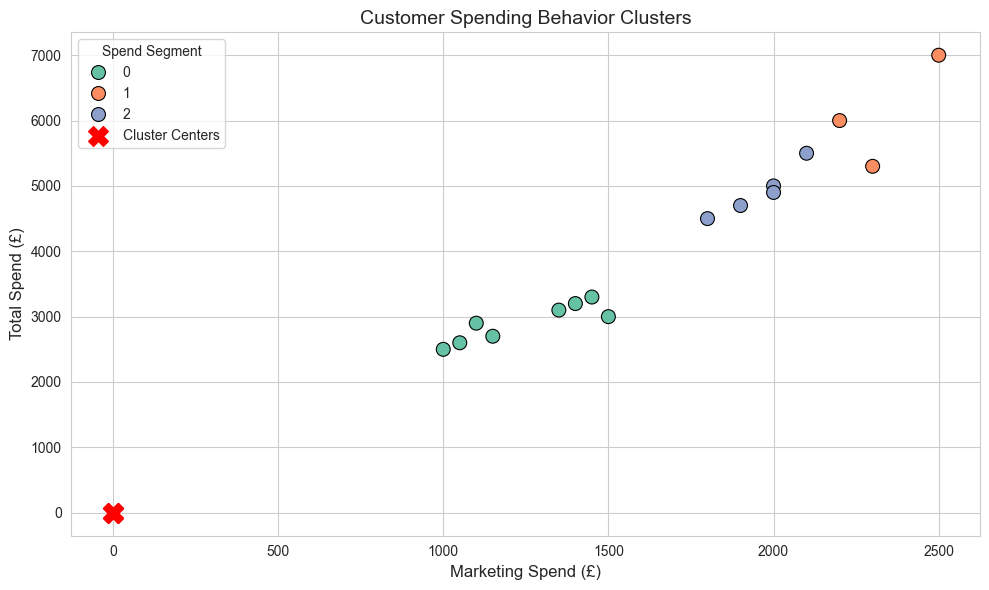

               Total_Spend  Marketing_Spend  Purchase_Frequency
Spend_Segment                                                  
0                   2912.5          1250.00                6.75
1                   6100.0          2333.33               14.00
2                   4920.0          1960.00               11.20
   Customer_Name  Total_Spend Spend_Segment_Label
0       John Doe         5000    Growth Potential
1     Jane Smith         3000    Budget Conscious
2      Sam Brown         4500    Growth Potential
3  Linda Johnson         2500    Budget Conscious
4    Michael Lee         7000          High Value


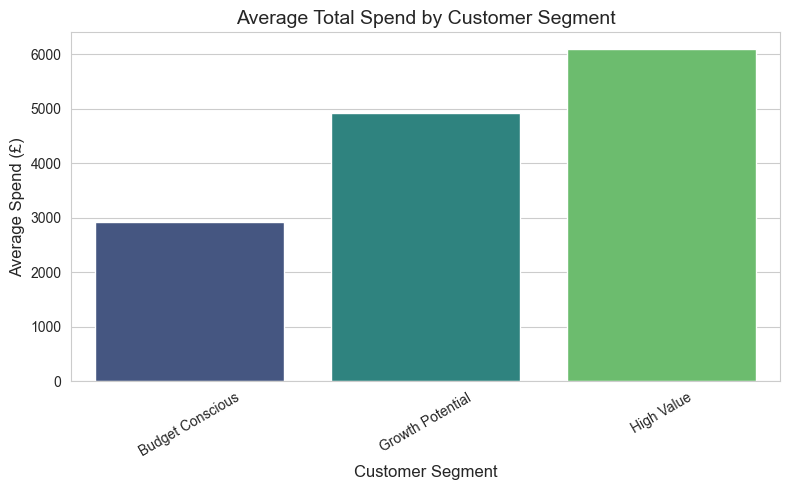

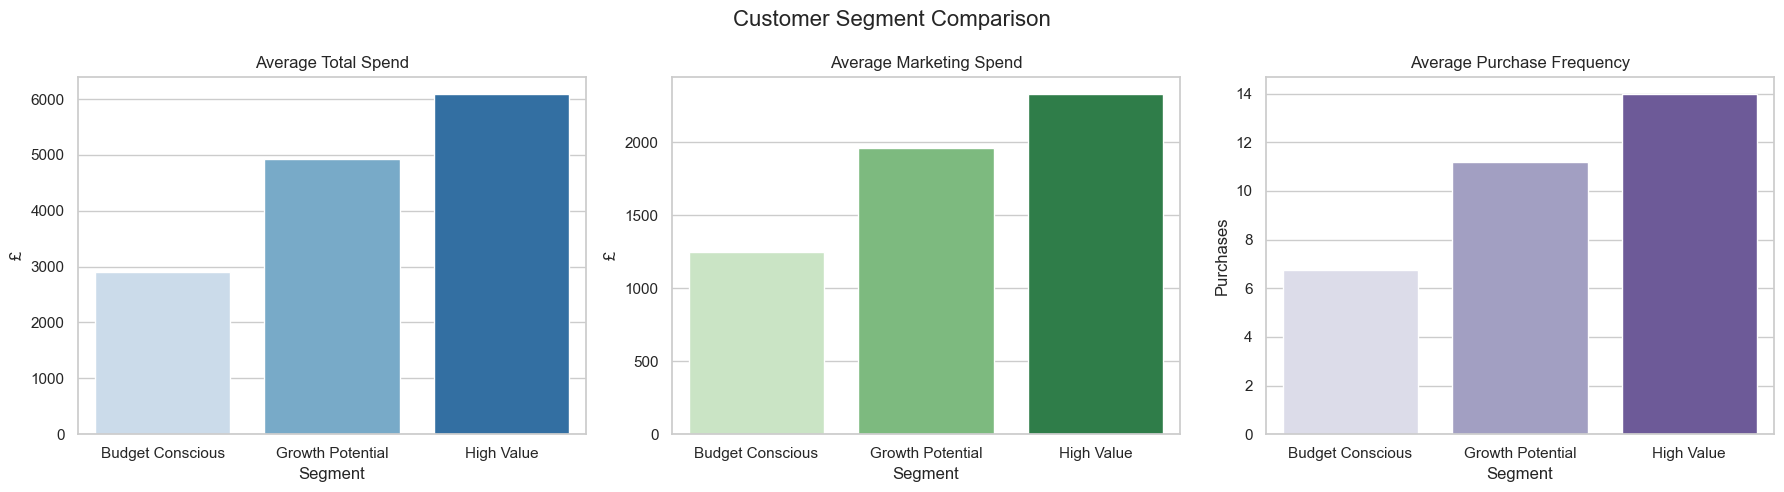

In [8]:
#Customer Spending Clusters

# Defining plot style
sns.set_style(style="whitegrid")

# Ploting clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x='Marketing_Spend',
    y='Total_Spend',
    hue='Spend_Segment',
    palette='Set2',
    s=100,
    edgecolor='black'
)

# Ploting cluster centers
centers = kmeans.cluster_centers_
plt.scatter(
    centers[:, 1],  # Total_Spend is column 1
    centers[:, 0],  # Marketing_Spend is column 0
    c='red',
    s=200,
    marker='X',
    label='Cluster Centers'
)

# Add labels and title
plt.xlabel("Marketing Spend (£)", fontsize=12)
plt.ylabel("Total Spend (£)", fontsize=12)
plt.title("Customer Spending Behavior Clusters", fontsize=14)
plt.legend(title="Spend Segment")
plt.tight_layout()
plt.show()

cluster_summary = df.groupby('Spend_Segment')[['Total_Spend', 'Marketing_Spend', 'Purchase_Frequency']].mean().round(2)
print(cluster_summary)

segment_labels = {
    0: 'Budget Conscious',
    1: 'High Value',
    2: 'Growth Potential'
}

df['Spend_Segment_Label'] = df['Spend_Segment'].map(segment_labels)
print(df[['Customer_Name', 'Total_Spend', 'Spend_Segment_Label']].head())


# Average Spend by Segment
# Set style
sns.set_style(style="whitegrid")

# Group and plot
segment_avg_spend = df.groupby('Spend_Segment_Label')['Total_Spend'].mean().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(data=segment_avg_spend, x='Spend_Segment_Label', y='Total_Spend', palette='viridis')

plt.title("Average Total Spend by Customer Segment", fontsize=14)
plt.xlabel("Customer Segment", fontsize=12)
plt.ylabel("Average Spend (£)", fontsize=12)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


# Multi-Metric Comparison: Bar Chart with Subplots
# Preparing summary data
segment_summary = df.groupby('Spend_Segment_Label')[['Total_Spend', 'Marketing_Spend', 'Purchase_Frequency']].mean().reset_index()

# defining plot style
sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

# Total Spend
sns.barplot(data=segment_summary, x='Spend_Segment_Label', y='Total_Spend', palette='Blues', ax=axes[0])
axes[0].set_title("Average Total Spend")
axes[0].set_xlabel("Segment")
axes[0].set_ylabel("£")

# Marketing Spend
sns.barplot(data=segment_summary, x='Spend_Segment_Label', y='Marketing_Spend', palette='Greens', ax=axes[1])
axes[1].set_title("Average Marketing Spend")
axes[1].set_xlabel("Segment")
axes[1].set_ylabel("£")

# Purchase Frequency
sns.barplot(data=segment_summary, x='Spend_Segment_Label', y='Purchase_Frequency', palette='Purples', ax=axes[2])
axes[2].set_title("Average Purchase Frequency")
axes[2].set_xlabel("Segment")
axes[2].set_ylabel("Purchases")

# Final layout
plt.suptitle("Customer Segment Comparison", fontsize=16)
plt.tight_layout()
plt.show()




In [9]:
# Random Forest Prediction

# Initialize the Random Forest model with 100 trees and a fixed random seed for reproducibility
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model using the training features and corresponding churn labels
random_forest_model.fit(features_train, labels_train) 

# Predict churn outcomes for the test set using the trained model
rf_churn_predictions = random_forest_model.predict(features_test)

# Print evaluation metrics to assess model performance on unseen data
print('Random Forest Results:')
print(classification_report(labels_test, rf_churn_predictions))



# XGBoost Churn Prediction

# Converting 'Yes'/'No' labels to numeric (1/0)
labels_train_numeric = labels_train.map({'No': 0, 'Yes': 1})
labels_test_numeric = labels_test.map({'No': 0, 'Yes': 1})

# Train XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(features_train, labels_train_numeric)

#  churn prediction
xgb_churn_predictions = xgb_model.predict(features_test)

# Evaluate performance
print("XGBoost Results:")
print(classification_report(labels_test_numeric, xgb_churn_predictions))



Random Forest Results:
              precision    recall  f1-score   support

          No       1.00      1.00      1.00         2
         Yes       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4

XGBoost Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4

